We want to use the model and algorithm of Tutorial--Van der Pol's dynamics with spike train observations.ipynb on the data in the folder Data. This notebook is used to create models for the data.

In [1]:
# Libraries
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import sys
import pickle

# .py
sys.path.append("..")
from inference import GaussMarkovLagrange
from likelihoods import PointProcess
from mappings import AffineMapping
from transition import FixedPointSparseGP, SparseGP
from kernels import RBF
from linkfunctions import Exp
from models import PointProcessGPSDEmodel, GPSDE
sys.path.append("../Data")
from Load_plot_data import load_neuron_data, roster_plot

# Load the data and modify its format

In [2]:
#Load data
ids,times=load_neuron_data('../Data/Cellline1_Date190328_Chip2135.npz')
N=np.max(ids) # Number of neurons
trLen=np.array([np.max(times)]) #Tmax must be an array to have one for each trial
print(trLen)

[897.9968]


The data from the files is of the form
( id : neurons ids,
times : times of spike )

For the model we need a list of array where array i contains the times at which neuron i had a spike

We can observe using unique and some tests that the ids are all the numbers between 0 and 1016 except 131 and 899. We suppose that they are not present beacause they didn't have a spike.

In [3]:
Yspike=[]
for i in range(N):
    Yspike.append(times[ids==i])
print(len(Yspike))

#For now there is only one trial, to change if we want to define trials
Yspike=[Yspike]

1016


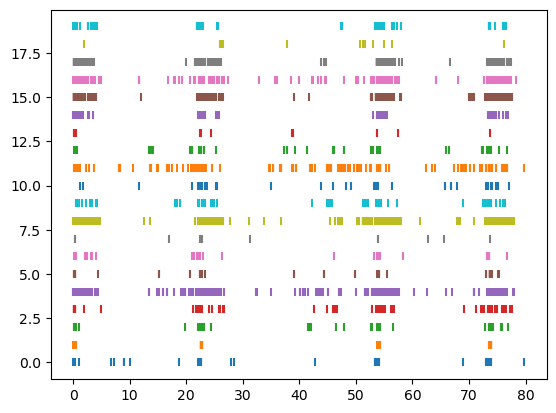

In [4]:
#Reduce the dataset (only one trial)
N=20
timemax=80

#Yspike=Yspike[0][:N] #keep only n first neuron

#seeds
torch.manual_seed(22)
np.random.seed(17) #C,d (very bad seed : 26,20)
random.seed(23) #neuron choice

#keep n most actives
#Yspike=Yspike[0]
#Yspike=sorted(Yspike,key=lambda x:x.shape[0],reverse=True)[:3*N]
#print(Yspike[-1].shape[0])
#random.shuffle(Yspike) #There is a problem when just the N first are taken (not semidefinite positive qsigma)
#Yspike=Yspike[:N]

#keep n not too actives but not 0
Yspike=Yspike[0]
Yspike=sorted(Yspike,key=lambda x:x.shape[0],reverse=True)[:800]
#print(Yspike[800].shape[0])
random.shuffle(Yspike) #There is a problem when just the N first are taken (not semidefinite positive qsigma)
Yspike=Yspike[:N]

for i in range(N):  #reduce the time
    Yspike[i]=Yspike[i][Yspike[i]<=timemax]
    plt.scatter(Yspike[i],i*np.ones(Yspike[i].shape[0]),marker='|')
plt.show()
Yspike=[Yspike]
trLen=np.array([timemax]) #Tmax must be an array to have one for each trial

# Choices for the model

In [5]:
#Choice of variables
#dtgrid = 0.004 # discretisation for solving ODEs ,seems to influence spd
dtgrid=0.008
xDim = 2 # two latents
lr=0.1

In [6]:
#Choice of model components
link = Exp() # exponential link function (to define nonlinearity in likelihood )
like = PointProcess(Yspike, link, trLen, dtstep=dtgrid, nLeg=100) # point process likelihood 
kern = RBF(xDim) # RBF kernel

#To initialize the Affine mapping from latent to observations
C = 3.*np.random.rand(xDim,N) * np.random.choice([-1,1],size=(xDim,N)) #before : 2.
#C = 2.*np.random.rand(xDim,N) 
d = 0.1*np.random.randn(1,N)
outputMapping = AffineMapping(torch.tensor(C), torch.tensor(d)) # affine output mapping, used inn the forward of the model

In [7]:
#Choose the inducing points and transition function
#how to choose the inducing points? how to choose the number of inducing points ?

# generater inducing point locations on a 2D grid (for sparse gp)
xmin, xmax = -20, 20
numZ = 5 #need more memory to increase
Zs1, Zs2 = torch.meshgrid([torch.linspace(xmin,xmax,numZ), torch.linspace(xmin,xmax,numZ)])
Zs = torch.cat((Zs1.reshape(-1,1),Zs2.reshape(-1,1)),dim=1)
#print(Zs)

transfunc = SparseGP(kern, Zs) # choose sparse GP as a transition function

# uncomment to instead condition on fixed points
Zs_fx = torch.tensor([0., 0.]).view(-1,xDim)
#print(Zs_fx)
#transition function conditioned on fixed point
#transfunc = FixedPointSparseGP(kern,Zs, Zs_fx)  
transfunc.q_mu.data = torch.randn(transfunc.q_mu.size()).type(torch.float64) # random initialisation for inducing point posterior mean
print(transfunc.q_mu)

tensor([[ 0.3920,  0.0734],
        [-0.0045, -0.0535],
        [-0.0589,  0.6002],
        [ 2.0421,  1.3273],
        [-0.8703, -1.5555],
        [-0.8620, -0.1290],
        [ 1.4632,  0.2698],
        [-1.3583, -0.7568],
        [-0.4102,  0.2939],
        [-0.0538, -0.9547],
        [-1.3138,  0.4306],
        [-1.3356,  1.1686],
        [ 0.9662, -1.7636],
        [-1.9802, -0.0056],
        [ 0.8050,  0.7928],
        [-0.6498,  0.0352],
        [-1.1281,  0.8134],
        [ 0.7393, -0.0455],
        [-1.7682, -0.1843],
        [-1.3310,  0.5904],
        [-0.8815,  0.3312],
        [ 1.0861, -0.0626],
        [ 1.0136, -0.7909],
        [-0.5482,  1.1483],
        [ 0.3265, -0.1000]], dtype=torch.float64)


c:\Users\fosmo\anaconda3\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Build the model

In [8]:
#Build the model

# build point procces generative model for continuous time spike-time observations
model = PointProcessGPSDEmodel(xDim, transfunc, outputMapping, like, nLeg=100)

# assemble inference algorithm
inference = GaussMarkovLagrange(xDim, trLen, learningRate=lr, dtstep=dtgrid) #learning rate try 0.1

# create GPSDE model object (final object)
myGPSDE = GPSDE(model, inference)

# fix inducing points on chosen grid
myGPSDE.model.transfunc.Zs.requires_grad = False

# Run the algorithm and save the results

small : 10 neurons, 60s , dt=0.004, no random just the first

100_60 : 100 neurons, 60s, dt=0.004, seed =30 neurons in the 3*N more active, 10 iter of each

200_120: 200 neurons, 120s,dt=0.004, seed=27 (180 min), 10 iter of each, neurons in the 3*N more active

Seed on C and d.

Fix the inducing points => try no closed form and btw -25 and 25, try between -25 and 25 + replace nan with var_ini in the setting ( probably need to change to avoid loop => create not pd matrix problem), try -10,10 => faster but mistake at the same step, Try to reduce the learning number of steps, try to have initial var of 1 and initial mu of 0


choose C,d,inducing points,number of inducing points,mean of inducing point, if closed form is used (if not a qsigma and qmu are parameters), the inducing point are parameter (one try where didn't change ??), what is jitter level ? choose var_init



After meeting :
var_ini=1, mu_ini=0
first : all iter =5, xmin 10, lr=0.1 =>fail after 1st iter

try to increase C : 10 in front =>fail very quickly =>return to 2, transform output scale to not a para
xmin to 5

estep and mstep iter need to be big enough not to fail

200_120_b : torch.manual_seed(26) np.random.seed(11) random.seed(27) 3 in front of C , xmin, xmax = -25, 25, 25 pt,lr=0.1, var_init = 0.1, 10 iter of each

Now try to reput kernel output as Para =>longer and not better kernpara

Then try to change mu ini = >not much change
Try different lr, change to -10,10 =>better model 241127, try to raise to 50 inducing points = >don't change much _50, maybe a bit quicker?,  try to put para in kernel again =>no change remove it _50kernpara

Try -5,5, no para kernel 50_5 => a lot faster and different result, try -2,2 50_2

Try another set of neurons, -5,5, no para kern, lr=0.1, now do it for 16 iteration while saving at each =>model by iter correspond to seeds torch.manual_seed(24), np.random.seed(11) , random.seed(25) 

everything the same except we do -100 and 6 iter, for the two neurons seed
correction of the number of inducing points => now it take into account, before it didn't change anything, but don't have enough memory to run more than 5x5 grid even when reducing the number of neurons thus bad result on 100 ? try with 50 instead

to have better results on 100, use fixed point => work well for seed 25 but not  so well for seed 27, focus on seed 25 and try to reduce to -65 as the cycle is at 50

Try to do on 80s with 70 for fixed, seed 22 for ini mu

On 80s, 10neurons, -20,20, try to change seed for C,d and seed neurons, try to choose neurons with less spike
Try to change dt

In [9]:
myGPSDE.variationalEM(niter=6,eStepIter=10, mStepIter=10) #less iteration

c:\Users\fosmo\OneDrive\Documents\GitHub\gp-sde\demos\..\kernels.py:321: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ..\aten\src\ATen\native\BatchLinearAlgebra.cpp:766.)
  scaled_diffs, _ = torch.solve(mu_x2_new_diffs.transpose(-1, -2), lengthscales_new_squared.unsqueeze(-3))


inference time=131.12358450889587
learning time=5.046912670135498
update time0.0
-------------------------------------------------------
iter   objective    log-like      kl-div     f-prior
-------------------------------------------------------
   0    -587.599    1045.054     454.193      -3.262
inference time=264.6731958389282
learning time=6.02596640586853
update time0.0010020732879638672
   1   -1739.370    2219.894     477.267      -3.257
inference time=424.49501180648804
learning time=5.656140565872192
update time0.0
   2   -1993.591    2444.860     447.950      -3.319
inference time=572.3186690807343
learning time=5.478329420089722
update time0.0010006427764892578
   3   -2108.124    2539.409     427.946      -3.340
inference time=721.9697871208191
learning time=5.37941575050354
update time0.0
   4   -2185.837    2605.842     416.300      -3.705
inference time=871.7890954017639
learning time=5.505177974700928
update time0.0
   5   -2231.500    2638.985     400.641      -6.843


In [10]:
#Save the results
name="20_80_221724_20_6iter_allneuron800_dt0.05"
torch.save(myGPSDE.model,'Graph_and_modelsave/GPSDE_model_'+name+'.pt')
with open("Graph_and_modelsave/GPSDE_inference_"+name+".pkl",'wb') as file:
    pickle.dump(myGPSDE.inference,file)

with open("Graph_and_modelsave/GPSDE_"+name+".pkl",'wb') as file:
    pickle.dump(myGPSDE,file)

# Open the results

In [11]:
model=torch.load('Graph_and_modelsave/GPSDE_model_'+name+'.pt')
with open("Graph_and_modelsave/GPSDE_inference_"+name+".pkl",'rb') as file:
    inference=pickle.load(file)

# Visualisation

In [12]:
idx = 0 #trial considered
testTimes = torch.linspace(0,trLen[idx],int(trLen[idx]/0.001)) #testing times

m, S = inference.predict_marginals(idx, testTimes) #evaluate gp at new points for trial idx 
mr, Sr, Corth = model.outputMapping.orthogonaliseLatents(m,S) # orthogonalized subspace =>scalling and projection, compare

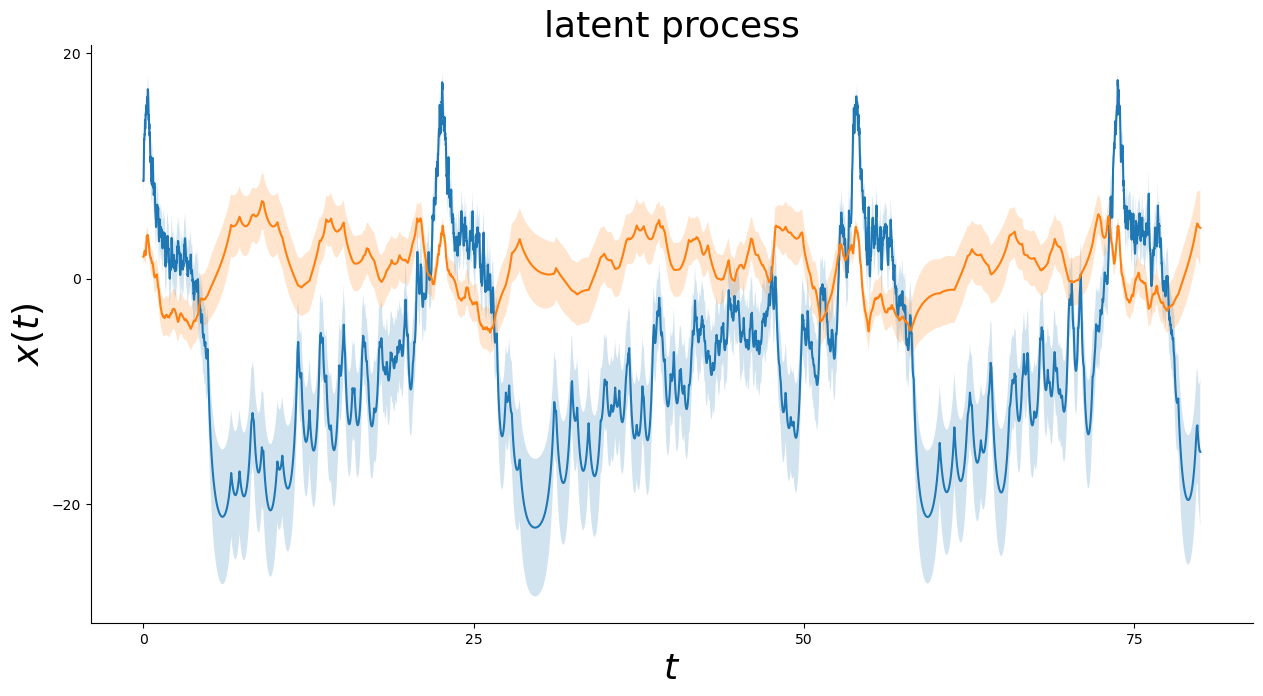

In [13]:
# plot the latent path and data in orthogonalised subspace
f, ax = plt.subplots()
f.set_figheight(7.5)
f.set_figwidth(15)
for i in range(xDim):
#     ax.plot(testTimes.numpy(),xpath[idx],color='black',linewidth=0.5,label='x(t)')
    ax.plot(testTimes.numpy(),mr[:,0,i].detach().squeeze().numpy(), label='$m_x(t)$')
    ax.fill_between(testTimes.numpy(), mr[:,0,i].detach().numpy()+np.sqrt(Sr[:,i,i].detach().numpy()), 
                mr[:,0,i].detach().squeeze().numpy()-np.sqrt(Sr[:,i,i].detach().numpy()), alpha=0.2)

# plot where observations lie
ax.locator_params(nbins=4)
ax.set_ylabel('$x(t)$',fontsize=26)
ax.set_xlabel('$t$',fontsize=26)
ax.set_title('latent process',fontsize=26)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('Graph_and_modelsave/Latent_graph_'+name+'.pdf')
plt.show()

In [14]:
# visualise learned transition function 
ngrid = 200
xmin = -25 #modify
xmax = 25
x = torch.linspace(xmin,xmax,ngrid)
#print(x)
y = torch.linspace(xmin,xmax,ngrid)

xv, yv = torch.meshgrid([x, y])
xygrid = torch.cat((yv.reshape(-1, 1),xv.reshape(-1, 1)),dim=1)
out_est = model.transfunc.predict(xygrid.unsqueeze(0))

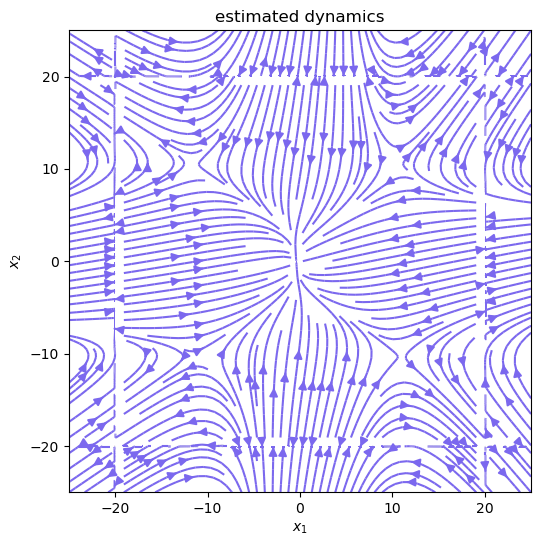

In [15]:
# visualise dynamics
sz = 6
plt.figure(figsize=(sz,sz))
#print(xv.numpy())
plt.streamplot(x.numpy(), y.numpy(), out_est[0,:,0].detach().reshape(ngrid,ngrid).numpy(), 
           out_est[0,:,1].detach().numpy().reshape(ngrid, ngrid), arrowsize=1.2, 
                  density=2, color='mediumslateblue')

        
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('estimated dynamics')
plt.axis('square')
plt.savefig('Graph_and_modelsave/dynamics_'+name+'.pdf')
plt.show()

# Multiple visualisation

0
1
2
3
4
5
6
7


KeyboardInterrupt: 

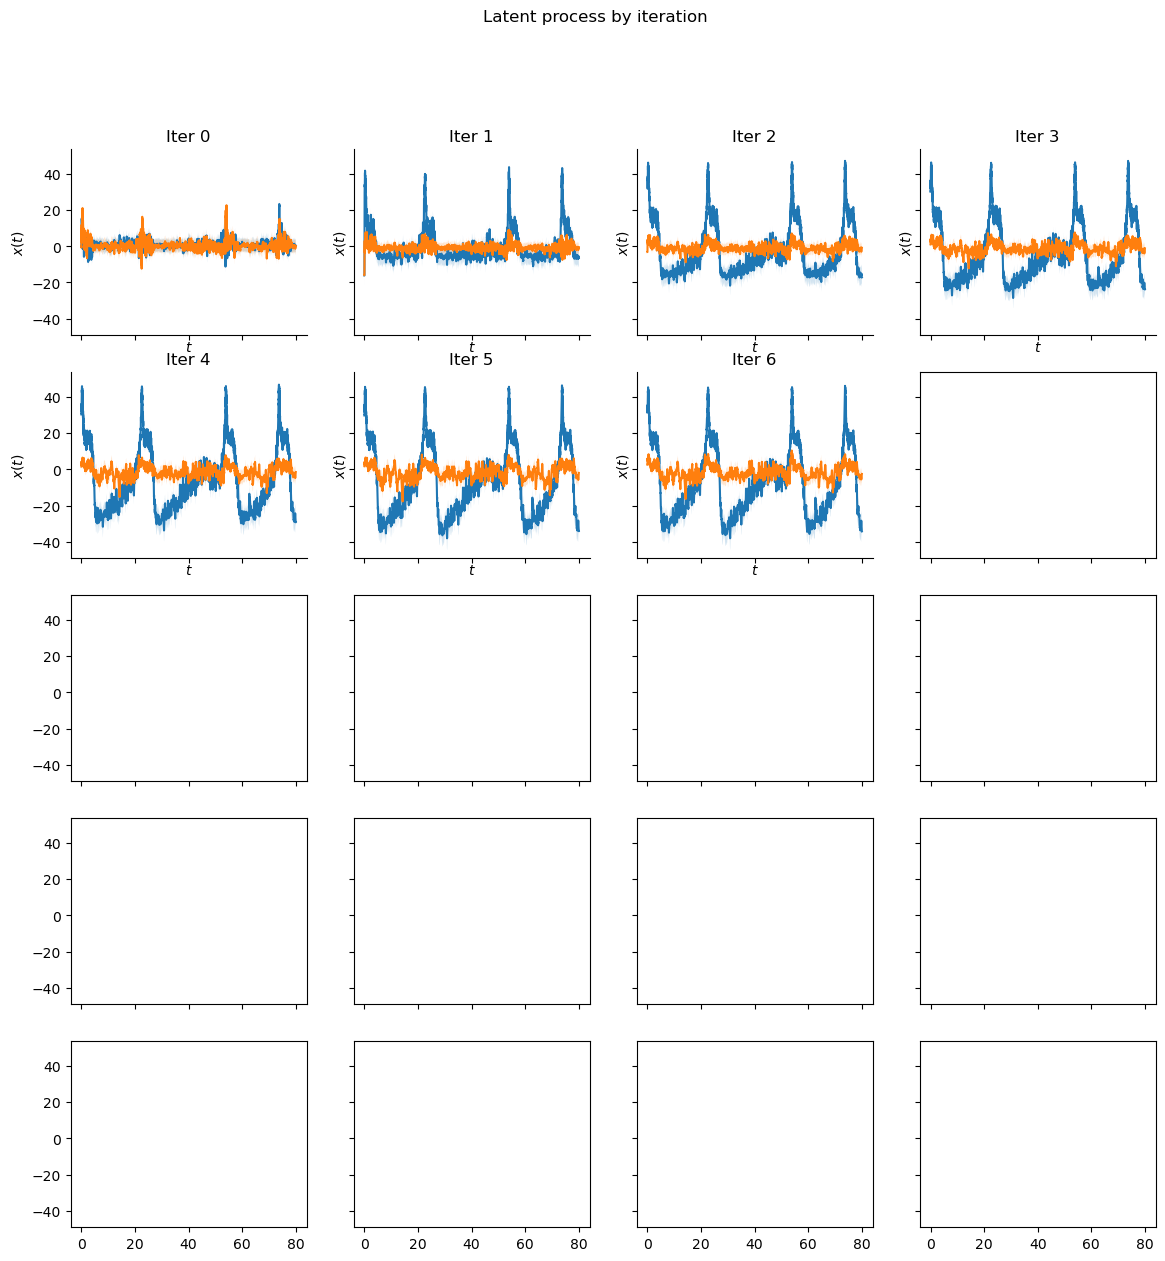

In [16]:
#latent path
total_iter=16
idx = 0 #trial considered
testTimes = torch.linspace(0,trLen[idx],int(trLen[idx]/0.001)) #testing times

f, ax = plt.subplots(5,4,sharex=True,sharey=True,figsize=(14,14))
f.suptitle("Latent process by iteration")

for j in range(total_iter+1):
    print(j)
    ax1=j//4
    ax2=j%4

    model=torch.load('Model_by_iter/model_'+str(j)+'.pt')
    with open('Model_by_iter/inference_'+str(j)+'.pt','rb') as file:
        inference=pickle.load(file)
    
    m, S = inference.predict_marginals(idx, testTimes) #evaluate gp at new points for trial idx 
    mr, Sr, Corth = model.outputMapping.orthogonaliseLatents(m,S) # orthogonalized subspace 

    for i in range(xDim):
        ax[ax1,ax2].plot(testTimes.numpy(),mr[:,0,i].detach().squeeze().numpy(), label='$m_x(t)$')
        ax[ax1,ax2].fill_between(testTimes.numpy(), mr[:,0,i].detach().numpy()+np.sqrt(Sr[:,i,i].detach().numpy()), 
                mr[:,0,i].detach().squeeze().numpy()-np.sqrt(Sr[:,i,i].detach().numpy()), alpha=0.2)
    ax[ax1,ax2].set_title('Iter '+str(j))
    ax[ax1,ax2].set_ylabel('$x(t)$')
    ax[ax1,ax2].set_xlabel('$t$')
    ax[ax1,ax2].spines['right'].set_visible(False)
    ax[ax1,ax2].spines['top'].set_visible(False)

f.savefig('Model_by_iter/Latent_graphs.pdf')
plt.show()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16


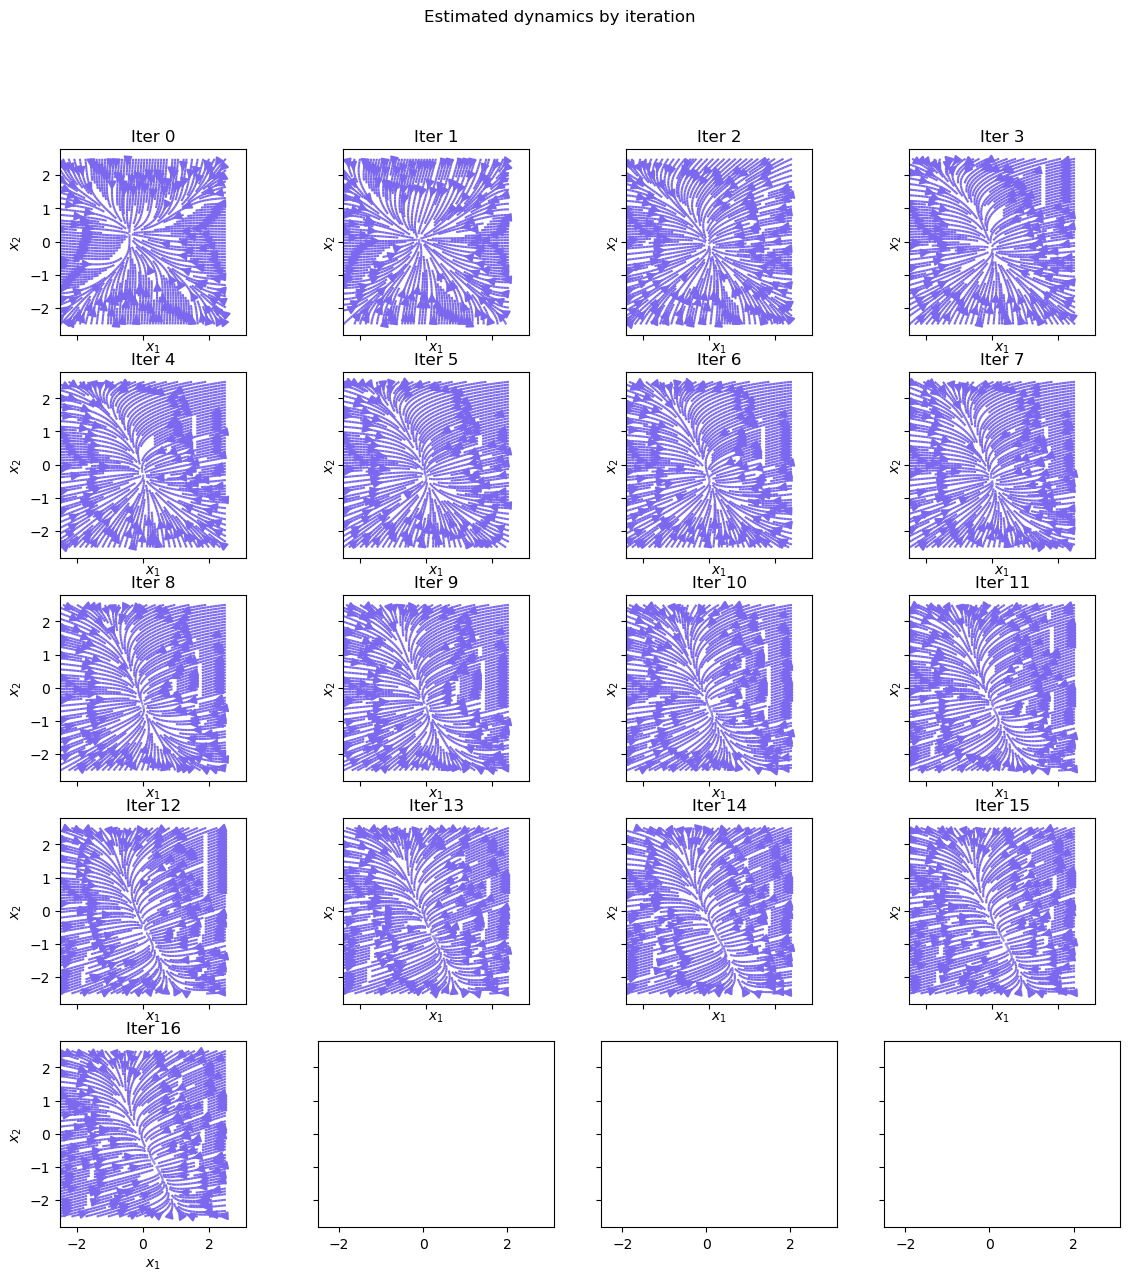

In [ ]:
#Dynamics

ngrid = 20
xmin = -2.5
xmax = 2.5
x = torch.linspace(xmin,xmax,ngrid)
y = torch.linspace(xmin,xmax,ngrid)

xv, yv = torch.meshgrid([x, y])
xygrid = torch.cat((yv.reshape(-1, 1),xv.reshape(-1, 1)),dim=1)

f, ax = plt.subplots(5,4,sharex=True,sharey=True,figsize=(14,14))
f.suptitle("Estimated dynamics by iteration")

for j in range(total_iter+1):
       print(j)
       ax1=j//4
       ax2=j%4
       model=torch.load('Model_by_iter/model_'+str(j)+'.pt')
       out_est = model.transfunc.predict(xygrid.unsqueeze(0))
       

       ax[ax1,ax2].streamplot(x.numpy(), y.numpy(), out_est[0,:,0].detach().reshape(ngrid,ngrid).numpy(), 
           out_est[0,:,1].detach().numpy().reshape(ngrid, ngrid), arrowsize=1.2, 
                  density=2, color='mediumslateblue')

       ax[ax1,ax2].set_title('Iter '+str(j))
       ax[ax1,ax2].set_xlabel('$x_1$')
       ax[ax1,ax2].set_ylabel('$x_2$')
       ax[ax1,ax2].axis('square')
       

f.savefig('Model_by_iter/Dynamics_graphs.pdf')
plt.show()